# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

## Setup
The setup code in this section was written to be [run in a Colab environment](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). For a full, local setup, we recommend the provided [conda environment](https://github.com/CompVis/taming-transformers/blob/master/environment.yaml), as [described in the readme](https://github.com/CompVis/taming-transformers#requirements). This will also allow you to run a streamlit based demo.

Here, we first clone the repository and download a model checkpoint and config.

Next, we install minimal required dependencies.

In [1]:
import sys
sys.path.append("..")
%cd ..

/mnt/taming-transformers


## Loading the model

We load and print the config.

In [2]:
from omegaconf import OmegaConf
config_path = "logs/2021-05-18T07-21-04_bw_transformer/configs/2021-05-18T07-21-04-project.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 8
    num_workers: 16
    train:
      params:
        config:
          size: 256
      target: taming.data.imagenet.ImageNetBWTrain
    validation:
      params:
        config:
          size: 256
      target: taming.data.imagenet.ImageNetBWValidation
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ckpt_path: logs/vqgan_imagenet_f16_16384/checkpoints/vqgan16384_bw.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 3
          num_res_blocks: 2
          out_ch: 3
          resolution: 256
          z_channels: 256
        embed_dim: 256
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 16384
      target: taming.models.vqgan.VQModel
    cond_sta

Instantiate the model.

In [3]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/vqgan_imagenet_f16_16384/checkpoints/vqgan16384.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/vqgan_imagenet_f16_16384/checkpoints/vqgan16384_bw.ckpt


In [4]:
import torch
torch.cuda.set_device(1)
torch.cuda.current_device()

1

Load the checkpoint.

In [5]:

ckpt_path = "logs/2021-05-18T07-21-04_bw_transformer/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

In [6]:
model.cuda().eval()
torch.set_grad_enabled(False)

In [7]:
import PIL
import torchvision.transforms as T
import torchvision.transforms.functional as TF
def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img
def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

## Load example data

Load an example segmentation and visualize.

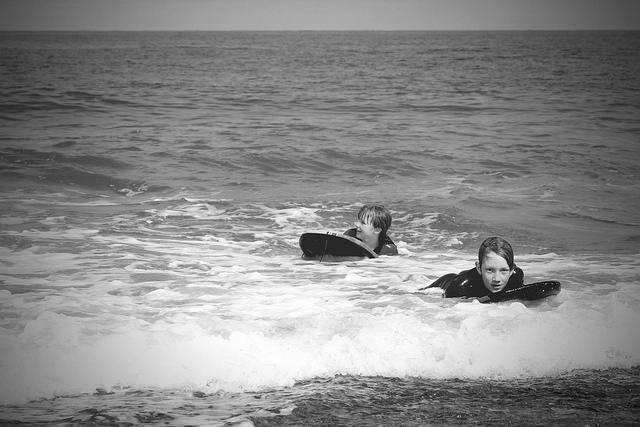

(427, 640, 3)


In [138]:

from PIL import Image
import numpy as np
bw_path = "data/bw/000000064898.jpg"
bw = Image.open(bw_path)
display(bw)
bw = np.array(bw)/255.0
bw = preprocess_vqgan(bw)
print(bw.shape)
bw = torch.tensor(bw.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)

Visualize

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

c_code torch.Size([1, 256, 26, 40]) torch.float32
c_indices torch.Size([1, 1040]) torch.int64
-1.0346389 1.025835
(416, 640, 3)


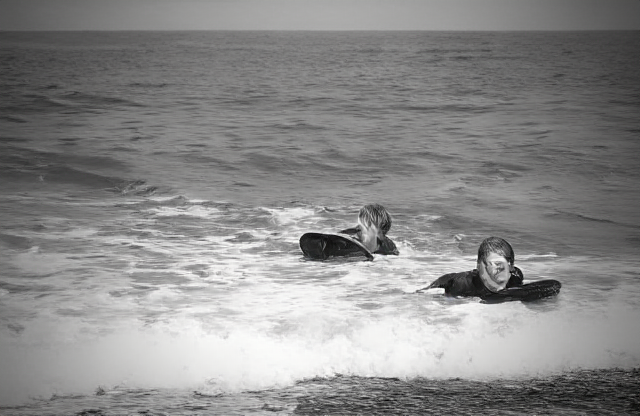

In [139]:
c_code, c_indices = model.encode_to_c(bw)
print("c_code", c_code.shape, c_code.dtype)
print("c_indices", c_indices.shape, c_indices.dtype)
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[1]
bw_rec = model.cond_stage_model.decode(c_code)
bw_rec = bw_rec.cpu().numpy()
print(np.min(bw_rec),np.max(bw_rec))
bw_rec = ((bw_rec+1.0)*127.5).clip(0,255).astype(np.uint8).transpose([0,2,3,1])[0]
print(bw_rec.shape)
display(Image.fromarray(bw_rec))

Let's sample indices corresponding to codes from the image VQGAN given the segmentation code. We init randomly and take a look.

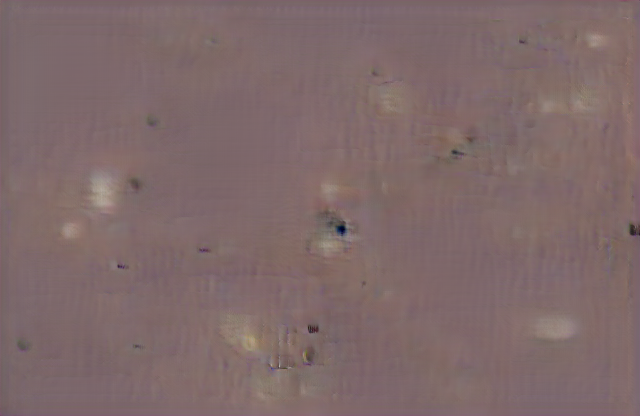

In [140]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices_shape = c_indices.shape
z_code_shape = c_code.shape
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code_shape)
show_image(x_sample)

## Sample an image

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

Time: 48.17830967903137 seconds
Step: (25,39) | Local: (15,15) | Crop: (10:26,24:40)


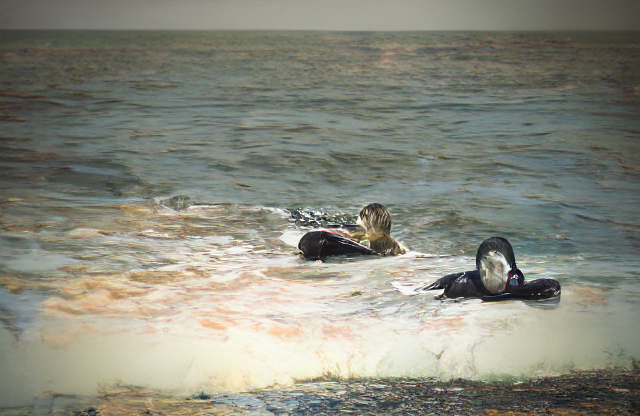

torch.Size([1, 3, 416, 640])


In [142]:
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.2
top_k = 256
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0):
  if i <= 8:
    local_i = i
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  else:
    local_i = 8
  for j in range(0,z_code_shape[3]-0):
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8

    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)
    patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1])
    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]

    logits = logits/temperature

    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      show_image(x_sample)
      print(x_sample.shape)